Importo las librerías

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hilbert

Armo la función para calcular los ceros

In [3]:
def calculate_zeros(signal, threshold=0):
    # Find the indices where signal crosses zero from positive to negative
    zero_crossings = np.where(np.diff(np.sign(signal - threshold)) != 0)[0]

    return zero_crossings

def calculate_periods(signal, N, dt, threshold=0):
    periods = np.zeros(N)
    zero_crossings = calculate_zeros(signal)
    wind = len(signal) / N

    for i in range(N):
        n_i = len(np.where((zero_crossings >= i*wind) & (zero_crossings < (i+1)*wind))[0])
        t_n_1 = zero_crossings[np.where(zero_crossings >= i*wind)[0][0]]*dt
        t_n_i = zero_crossings[np.where(zero_crossings <= (i+1)*wind)[0][-1]]*dt

        periods[i] = 2*(t_n_i - t_n_1) / (n_i - 1)
    
    return periods

0.6283185307179586

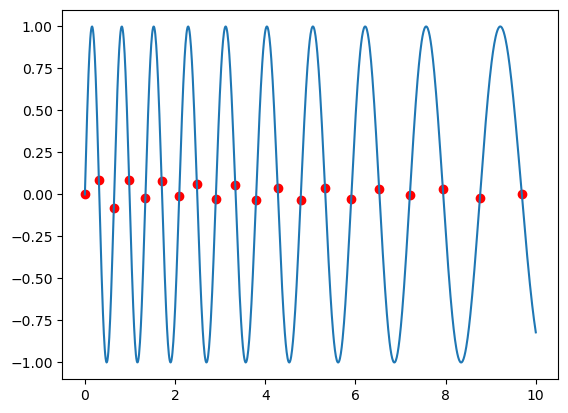

In [4]:
x = np.linspace(0, 10, 1000)
y = np.sin(10*np.exp(-x/20)*x)

ceros = calculate_zeros(y)

plt.plot(x, y)
plt.scatter(x[ceros], y[ceros], c='red')
#plt.xlim(0, 0.63)
2*np.pi/10

[0.67  0.815 0.99  1.2   1.46  1.86 ]


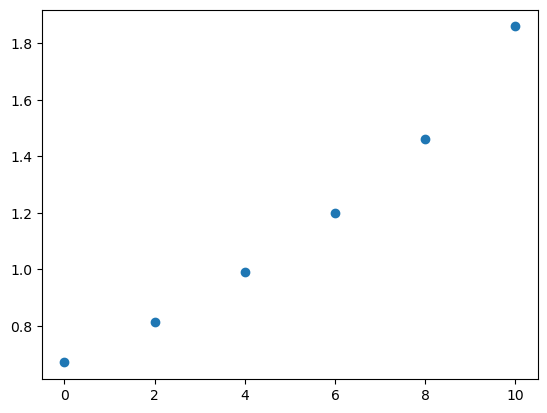

In [5]:
T = calculate_periods(y, 6, 0.01)

print(T)

plt.plot(np.linspace(0, 10, 6), T, 'o')

Probemos con el ring-down

In [6]:
x,y = np.loadtxt('/Users/manuchito/Documents/Balseiro/Investigación I/dia4_22-02/RD_non-linear_MEMS_1Mpoints_1Ms_filtered.csv', unpack=True, delimiter=',', skiprows=22) 

In [7]:
N = 100
p = calculate_periods(y, N, 1e-6)

71042.62557534558

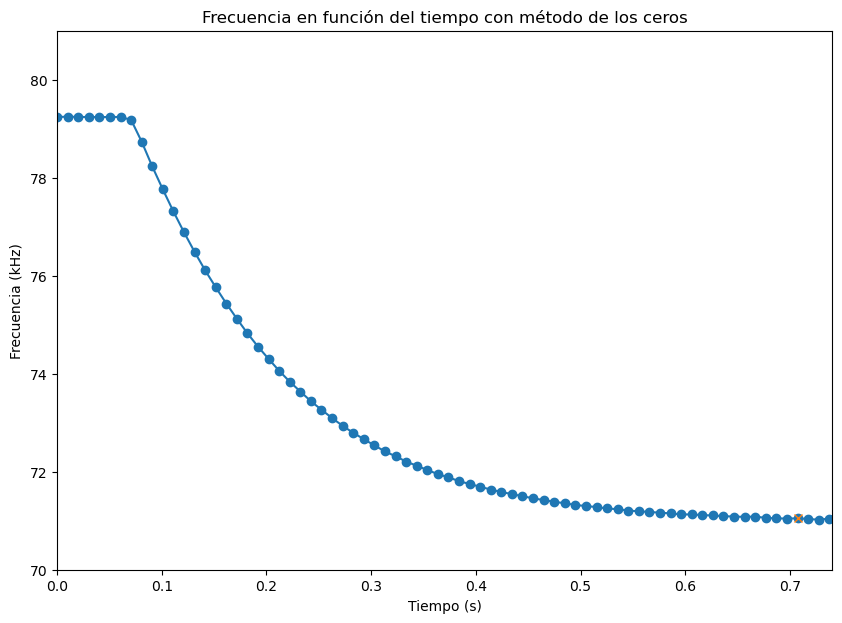

In [10]:
plt.figure(figsize=(10,7))
t = np.linspace(0, 1, N)
plt.plot(t, (1/p)/1000, 'o-')
plt.plot(t[70], (1/p[70])/1000, 'x')

plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (kHz)')
plt.xlim(0, 0.74)
plt.ylim(70, 81)
plt.title('Frecuencia en función del tiempo con método de los ceros')

1/p[f_max-1]

Lo intento ajustar exponencialmente

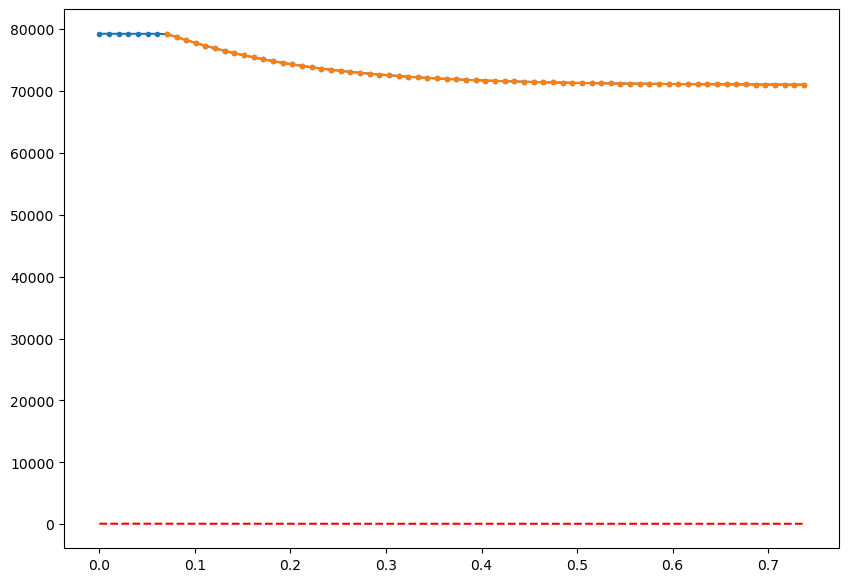

In [9]:
f_max = 74
f = (1/p[:f_max])
t_f = t[:f_max]

def expp(x, a, b, c, d):
    return (a-d)*np.exp(b*(x-c)) + d

plt.figure(figsize=(10,7))
plt.plot(t_f, f, '.-')
plt.plot(t_f[7:], f[7:], '.-')
plt.plot(t_f, expp(t_f, 79.237, -7, 0.07, 71.042), 'r--')

Frecuencia lineal f_0 = 70910.96269775486 ± 9.69752399015483 Hz
Coeficiente de Duffing gamma = 103485228952.98903 V-2 s-2
Coeficiente de disipación Gamma = 3.506088145311307 ± 0.018414012881712752 s-1


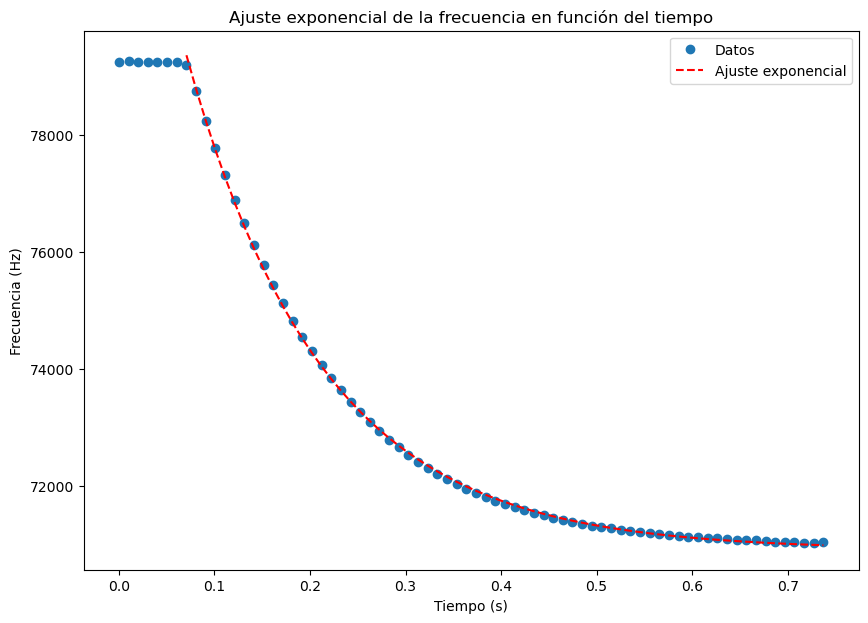

In [11]:
t_aj = t[7:f_max]
f_aj = f[7:]

def exp(x, a, b, c):
    return a*np.exp(b*x) + c

from scipy.optimize import curve_fit
popt, pcov = curve_fit(exp, t_aj, f_aj, p0=[79237, -7, 71042])

plt.figure(figsize=(10,7))
plt.plot(t_f, f, 'o', label='Datos')
plt.plot(t_aj, exp(t_aj, *popt), 'r--', label='Ajuste exponencial')
plt.xlabel('Tiempo (s)')
plt.ylabel('Frecuencia (Hz)')
plt.legend()
plt.title('Ajuste exponencial de la frecuencia en función del tiempo')

print(f"Frecuencia lineal f_0 = {popt[2]} ± {np.sqrt(np.diag(pcov))[2]} Hz")
print(f"Coeficiente de Duffing gamma = {32 * np.pi**2 * popt[0] * popt[2] / 3} V-2 s-2")
print(f"Coeficiente de disipación Gamma = {-popt[1]/2} ± {np.sqrt(np.diag(pcov))[1]/2} s-1")

Lo comparo con los datos obtenidos de STFT

In [12]:
t_o, f_o = np.loadtxt('/Users/manuchito/Documents/Balseiro/Investigación I/dia5_27-02/ring-down_27-02.csv', unpack=True, delimiter=',', skiprows=1)

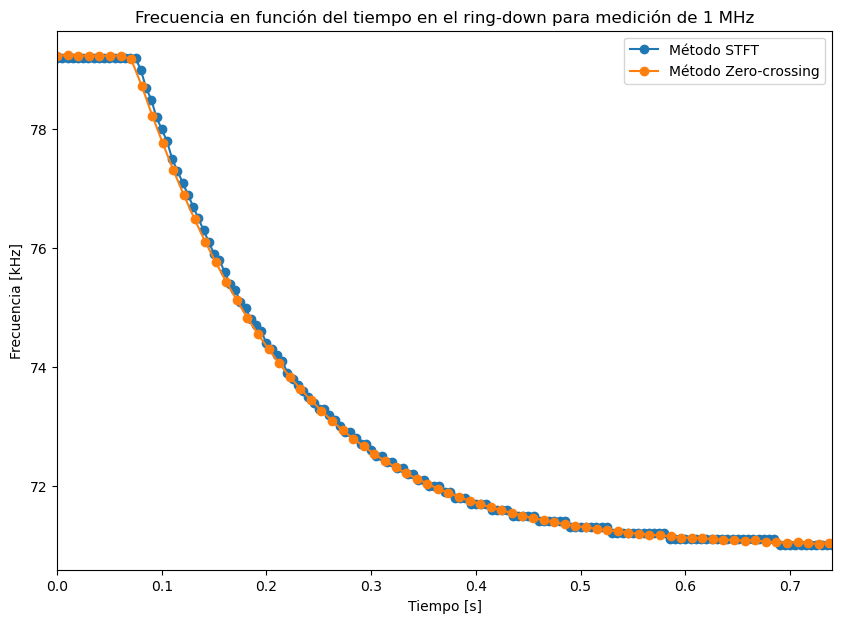

In [13]:
plt.figure(figsize=(10,7))
plt.plot(t_o, f_o/1000, 'o-', label='Método STFT')
plt.plot(t, (1/p)/1000, 'o-', label='Método Zero-crossing')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [kHz]')
plt.legend()
plt.xlim(0, 0.74)
plt.title('Frecuencia en función del tiempo en el ring-down para medición de 1 MHz')

plt.savefig('frecuencias_comparacion_1MHz.png', dpi=300)

Ahora lo hago para el otro ring-down

In [14]:
x2, y2 = np.loadtxt('/Users/manuchito/Documents/Balseiro/Investigación I/dia6_29-02/RD_non-linear_MEMS_5Mpoints_2.5Ms_filtered.csv', unpack=True, delimiter=',', skiprows=1)
x2_, y2_ = np.loadtxt('/Users/manuchito/Documents/Balseiro/Investigación I/dia6_29-02/ring_down_29-02_STFT.csv', unpack=True, delimiter=',', skiprows=1)

In [15]:
p2 = calculate_periods(y2, 100, 4e-7)
t2 = np.linspace(0, 1, len(p2))

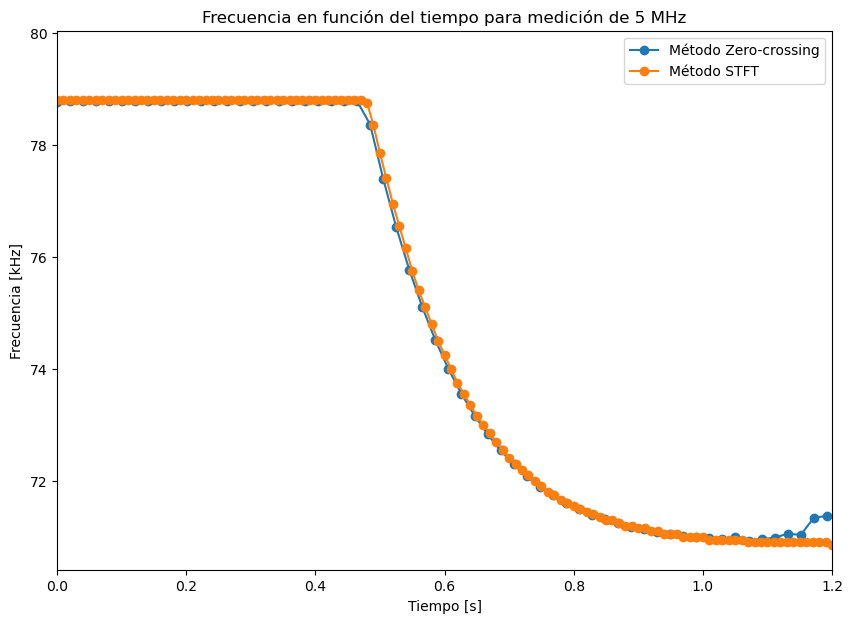

In [16]:
plt.figure(figsize=(10,7))
plt.plot(2*t2, (1/p2)/1000, 'o-', label = 'Método Zero-crossing')
plt.plot(x2_, y2_/1000, 'o-', label = 'Método STFT')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [kHz]')
plt.title('Frecuencia en función del tiempo para medición de 5 MHz')
plt.legend()
plt.xlim(0, 1.2)

plt.savefig('frecuencias_comparacion_2.5MHz.png', dpi=300)

Analizo el $\Gamma$ obtenido por la envolvente

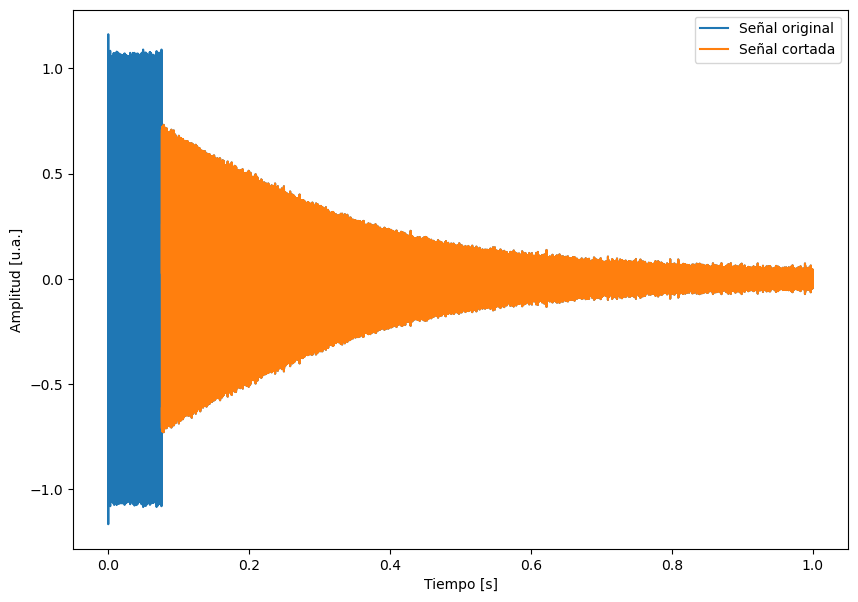

In [17]:
a = 76000

plt.figure(figsize=(10,7))
plt.plot(x, y, label='Señal original')
plt.plot(x[a:], y[a:], label='Señal cortada')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [u.a.]')
plt.legend()

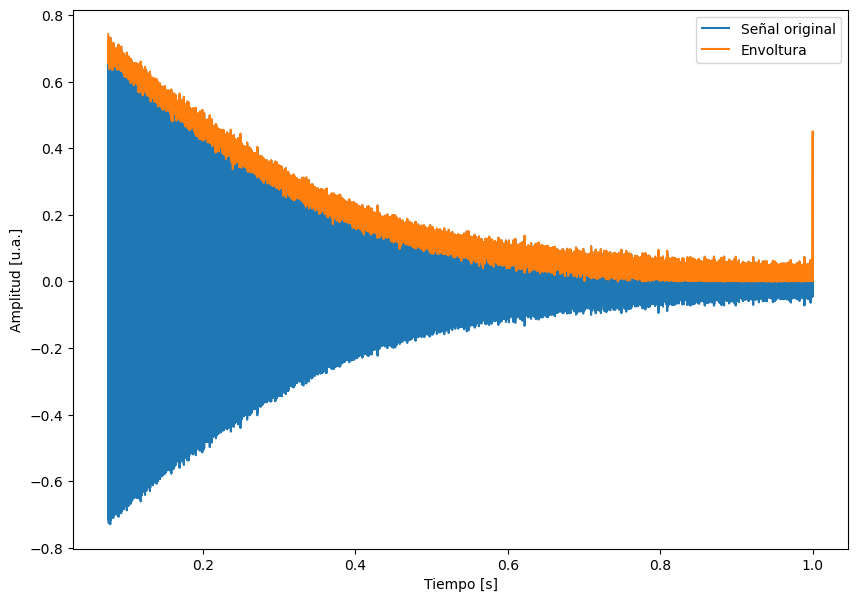

In [27]:
x_ = x[a:]
y_ = y[a:]

env = np.abs(hilbert(y_))
pha = np.unwrap(np.angle(hilbert(y_)))

plt.figure(figsize=(10,7))
plt.plot(x_, y_, label='Señal original')
plt.plot(x_, env, label='Envoltura')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [u.a.]')
plt.legend()

[ 0.98324164 -3.81577806 -0.00942682]
[0.00740577 0.05912382 0.00307702]


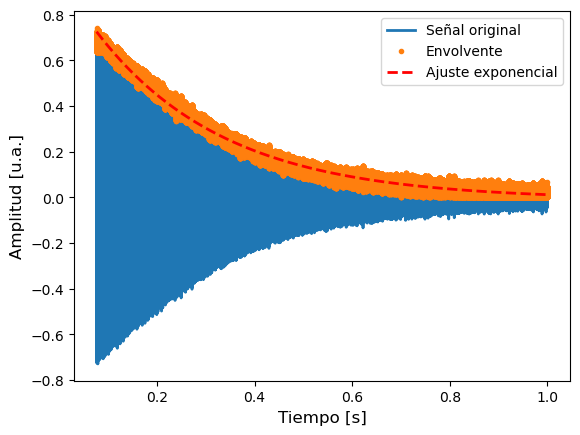

In [42]:
# Lo ajusto exponencialmente

popt_, pcov_ = curve_fit(exp, x_, env, p0=[0.7, -1, 0], absolute_sigma=True)

#plt.figure(figsize=(10,7))
plt.plot(x_, y_, '-', label='Señal original')
plt.plot(x_[:-5], env[:-5], '.', label='Envolvente')
plt.plot(x_, exp(x_, *popt_), 'r--', label='Ajuste exponencial')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [u.a.]')
plt.legend()
plt.savefig('envolvente_2.5MHz.png', dpi=300)

print(popt_)
print(np.sqrt(np.diag(pcov_)))

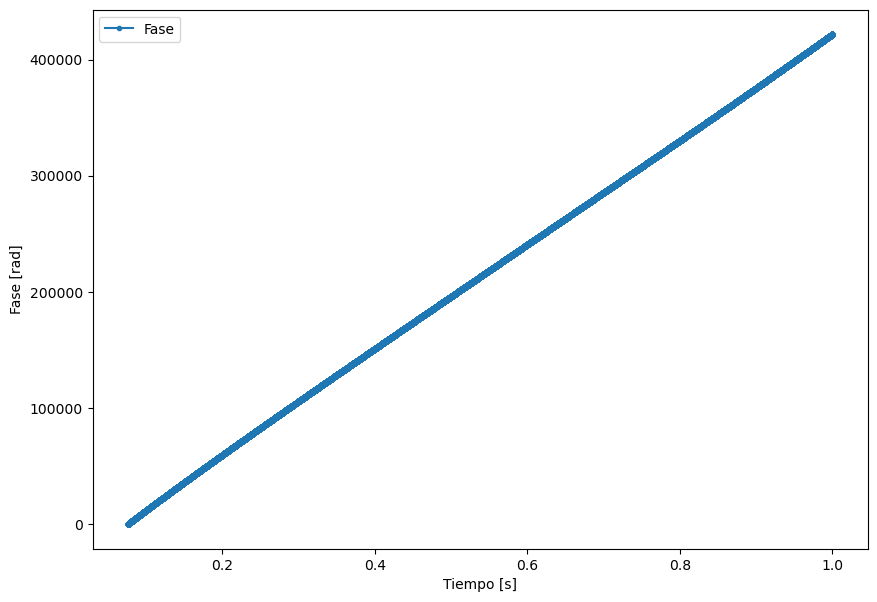

In [29]:
plt.figure(figsize=(10,7))
plt.plot(x_, pha, '.-', label='Fase')
plt.xlabel('Tiempo [s]')
plt.ylabel('Fase [rad]')
plt.legend()

In [37]:
plt.rcParams['figure.figsize'] = [6.4, 4.8]  # Figure size in inches
plt.rcParams['font.size'] = 10  # Font size
plt.rcParams['lines.linewidth'] = 2  # Line width
plt.rcParams['axes.labelsize'] = 12  # Axis label size

(70000.0, 80000.0)

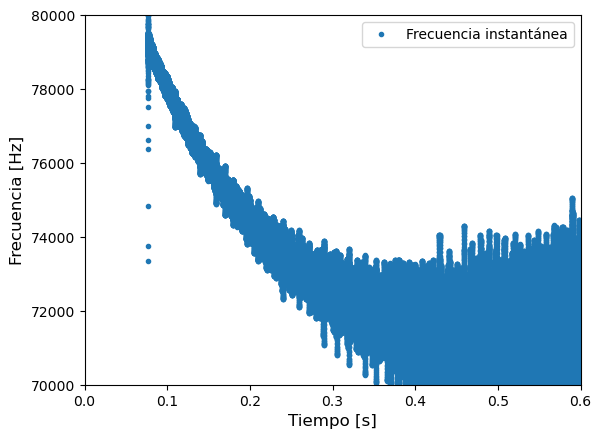

In [38]:
fs = 1e6
d_pha = (np.diff(pha) / (2.0*np.pi) * fs)

#plt.figure(figsize=(10,7))
plt.plot(x_[1:], d_pha, '.', label='Frecuencia instantánea')
plt.xlabel('Tiempo [s]')
plt.ylabel('Frecuencia [Hz]')
plt.legend()
plt.xlim(0, 0.6)
plt.ylim(70000, 80000)